# BSA Paper Plots

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from collections import OrderedDict
import numpy as np
import math
import pandas as pd
import pickle
import os
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import matplotlib.font_manager
import msprime, pyslim

plt.rcParams["font.family"] = "Arial"
flatui = ["#e74c3c", "#2ecc71", "#34495e"]
cmap = sns.color_palette(flatui)
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import markers
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 400
mpl.rcParams['font.size'] = 12
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=20) 
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['lines.markersize'] = 10
classic_kwargs = {'s': 20, 'edgecolors': 'k', 'c': 'b'}
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
# def uniqueish_color():
#     """There're better ways to generate unique colors, but this isn't awful."""
#     return plt.cm.gist_ncar(np.random.random())

## Functions for calculating the analytics of BSA genomic resolution

In [11]:
"""
    Calculate the BSA open-window resolution in infinite populations
"""
def calc_BSA_open_win_res_inf(r, s, t):
    return 1/(r*s*t)

"""
    Calculate the BSA open-window resolution in finite populations
"""
def calc_BSA_open_win_res_fin(Ne, r, s, t):
    D = 1/(2*Ne*r*np.log((2*s*(np.exp(t/(4*Ne))-1)+1)))
    return D

"""
    Calculate the BSA open-window resolution in finite populations with recursion
"""
def calc_BSA_open_win_res_recursion(Ne, r, s, t):
    tot_tree_len_bef_3 = sum([calc_nt_recursion_diploid(Ne, t, s) for t in range(t-2)])
    samples_at_3 = calc_nt_recursion_diploid(Ne, t-2, s)
    D = 1/(r*samples_at_3+r/2*tot_tree_len_bef_3)
    return D

"""
    Calculate the HS open-window resolution in finite populations
"""
def calc_HS_open_win_res_fin(Ne, r, s, t):
    D = 1/(2*Ne*r*np.log((2*s*(np.exp((t)/(2*Ne))-1)+1)))
    return D

"""
    Calculate the HS open-window resolution in finite populations with recursion
"""
def calc_HS_open_win_res_fin_recursion(Ne, r, s, t):
    tot_tree_len_bef_2 = sum([calc_nt_recursion_diploid(Ne/2, t, s) for t in range(t-1)])
    D = 1/(r*tot_tree_len_bef_2)
    return D

"""
    Calculate the IM open-window resolution in finite populations
"""
def calc_IM_open_win_res_fin(Ne, r, s, t):
    D = 1/(Ne/2*r*np.log((2*s*(np.exp((t)/(Ne))-1)+1)))
    return D

"""
    Calculate the IM open-window resolution in finite populations with recursion
"""
def calc_IM_open_win_res_fin_recursion(Ne, r, s, t):
    harmonic_Ne = t/(((t/2)/(Ne/4))+((t/2)/Ne))
    tot_tree_len_bef_2 = sum([calc_nt_recursion_diploid(harmonic_Ne, t, s) for t in range(t-1)])
    D = 1/(r/2*tot_tree_len_bef_2)
    return D


"""    
    Calculate the number of lineages expectation
"""
def calc_nt_recursion_diploid(Ne, t, s):
    if (t == 0):
        return 2*s
    elif (t == 1):
        return 2*Ne - 2*Ne*(1-1/(2*Ne))**(2*s)
    else:
        return 2*Ne - 2*Ne*(1-1/(2*Ne))**(calc_nt_recursion_diploid(Ne, t-1, s))

## Figure 1: Plot BSA Summary Statistic G'

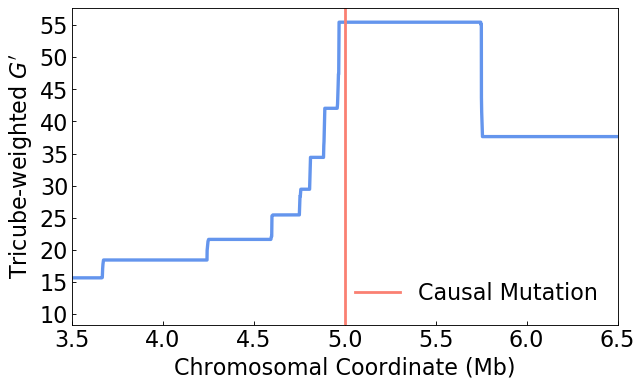

In [8]:
pckl_file = 'BSA_Resolution_vs_Statistics_1.0cM_Popsize_100_SampleSize_20.pckl'
with open(pckl_file, 'rb') as f:
    smoothed_dicts = pickle.load(f)

Ne = 100
R = '1e-8'
S = 20
T = 10

fig, ax = plt.subplots(1,1)
fig.set_size_inches((8.2,5))
ax.set_xlabel("Chromosomal Coordinate (Mb)", fontsize=20)
for dicts in smoothed_dicts:
    ### there are two statistics in the pickle file, but we are just gonna plot the G' statistic here
    smoothed_dict, tricube_weighted_Gprime_dict = dicts
    ax.plot(list(tricube_weighted_Gprime_dict.keys()), list(tricube_weighted_Gprime_dict.values()), linewidth=3,color='cornflowerblue')
    
ax.set_ylabel("Tricube-weighted $\it{G\'}$", fontsize=20)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim(3.5e6-1, 6.5e6+1)
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.set_xticklabels(ax.get_xticks())
ax.axvline(5e6, color='salmon', linewidth=2.5,label='Causal Mutation')

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [str(int(float(loc)) / 10**6) for loc in labels]
ax.set_xticklabels(labels)
ax.legend(fontsize=20, loc='best', frameon=False)
plt.tight_layout()
# plt.savefig('BSA_Summary_Stats_Ne_100_1cM_G_Only',dpi=400)

## Figure 4: Analytical solutions for the infinite and final popu-lation models

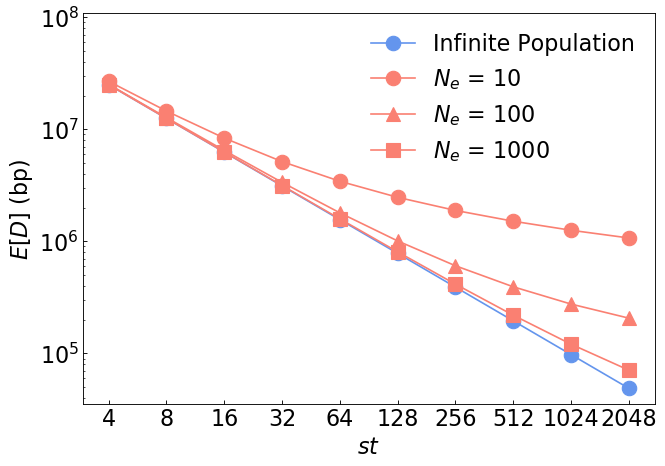

In [5]:
R = 1e-8
S_s = [2**x for x in range(1,11)]
T = 2
Nes = [10, 100, 1000]

fig, ax = plt.subplots()
fig.set_size_inches((8.5,6))
resolutions_inf = [calc_BSA_open_win_res_inf(float(R), S, T) for S in S_s]
ax.plot([str(s*T) for s in S_s], resolutions_inf, '-o', markersize=13, label='Infinite Population', color='cornflowerblue')
markers = ['-o', '-^', '-s']

for Ne in Nes:
    resolutions = [calc_BSA_open_win_res_fin(Ne, float(R), S, T) for S in S_s]
    ax.plot([str(s*T) for s in S_s], resolutions, markers[Nes.index(Ne)], markersize=13, label='$N_e$ = %s' % Ne, color='salmon')
    ax.set_xlabel("$st$", fontsize=20)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_ylabel("$E[D]$ (bp)", fontsize=20)
    ax.set_yscale('log', basey=10)
    ax.set_ylim((None, 10**7+1*10**8))
    ax.yaxis.set_tick_params(labelsize=20)
ax.legend(markerscale=1, loc='best', fontsize=20, frameon=False)
plt.tight_layout()
# plt.subplots_adjust(wspace = 0.15)
plt.savefig('BSA_Resolution_Analytics_Cannings_for_Paper.pdf', dpi=400)

## Figure 5: BSA Numerical Validation ($N_e$)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


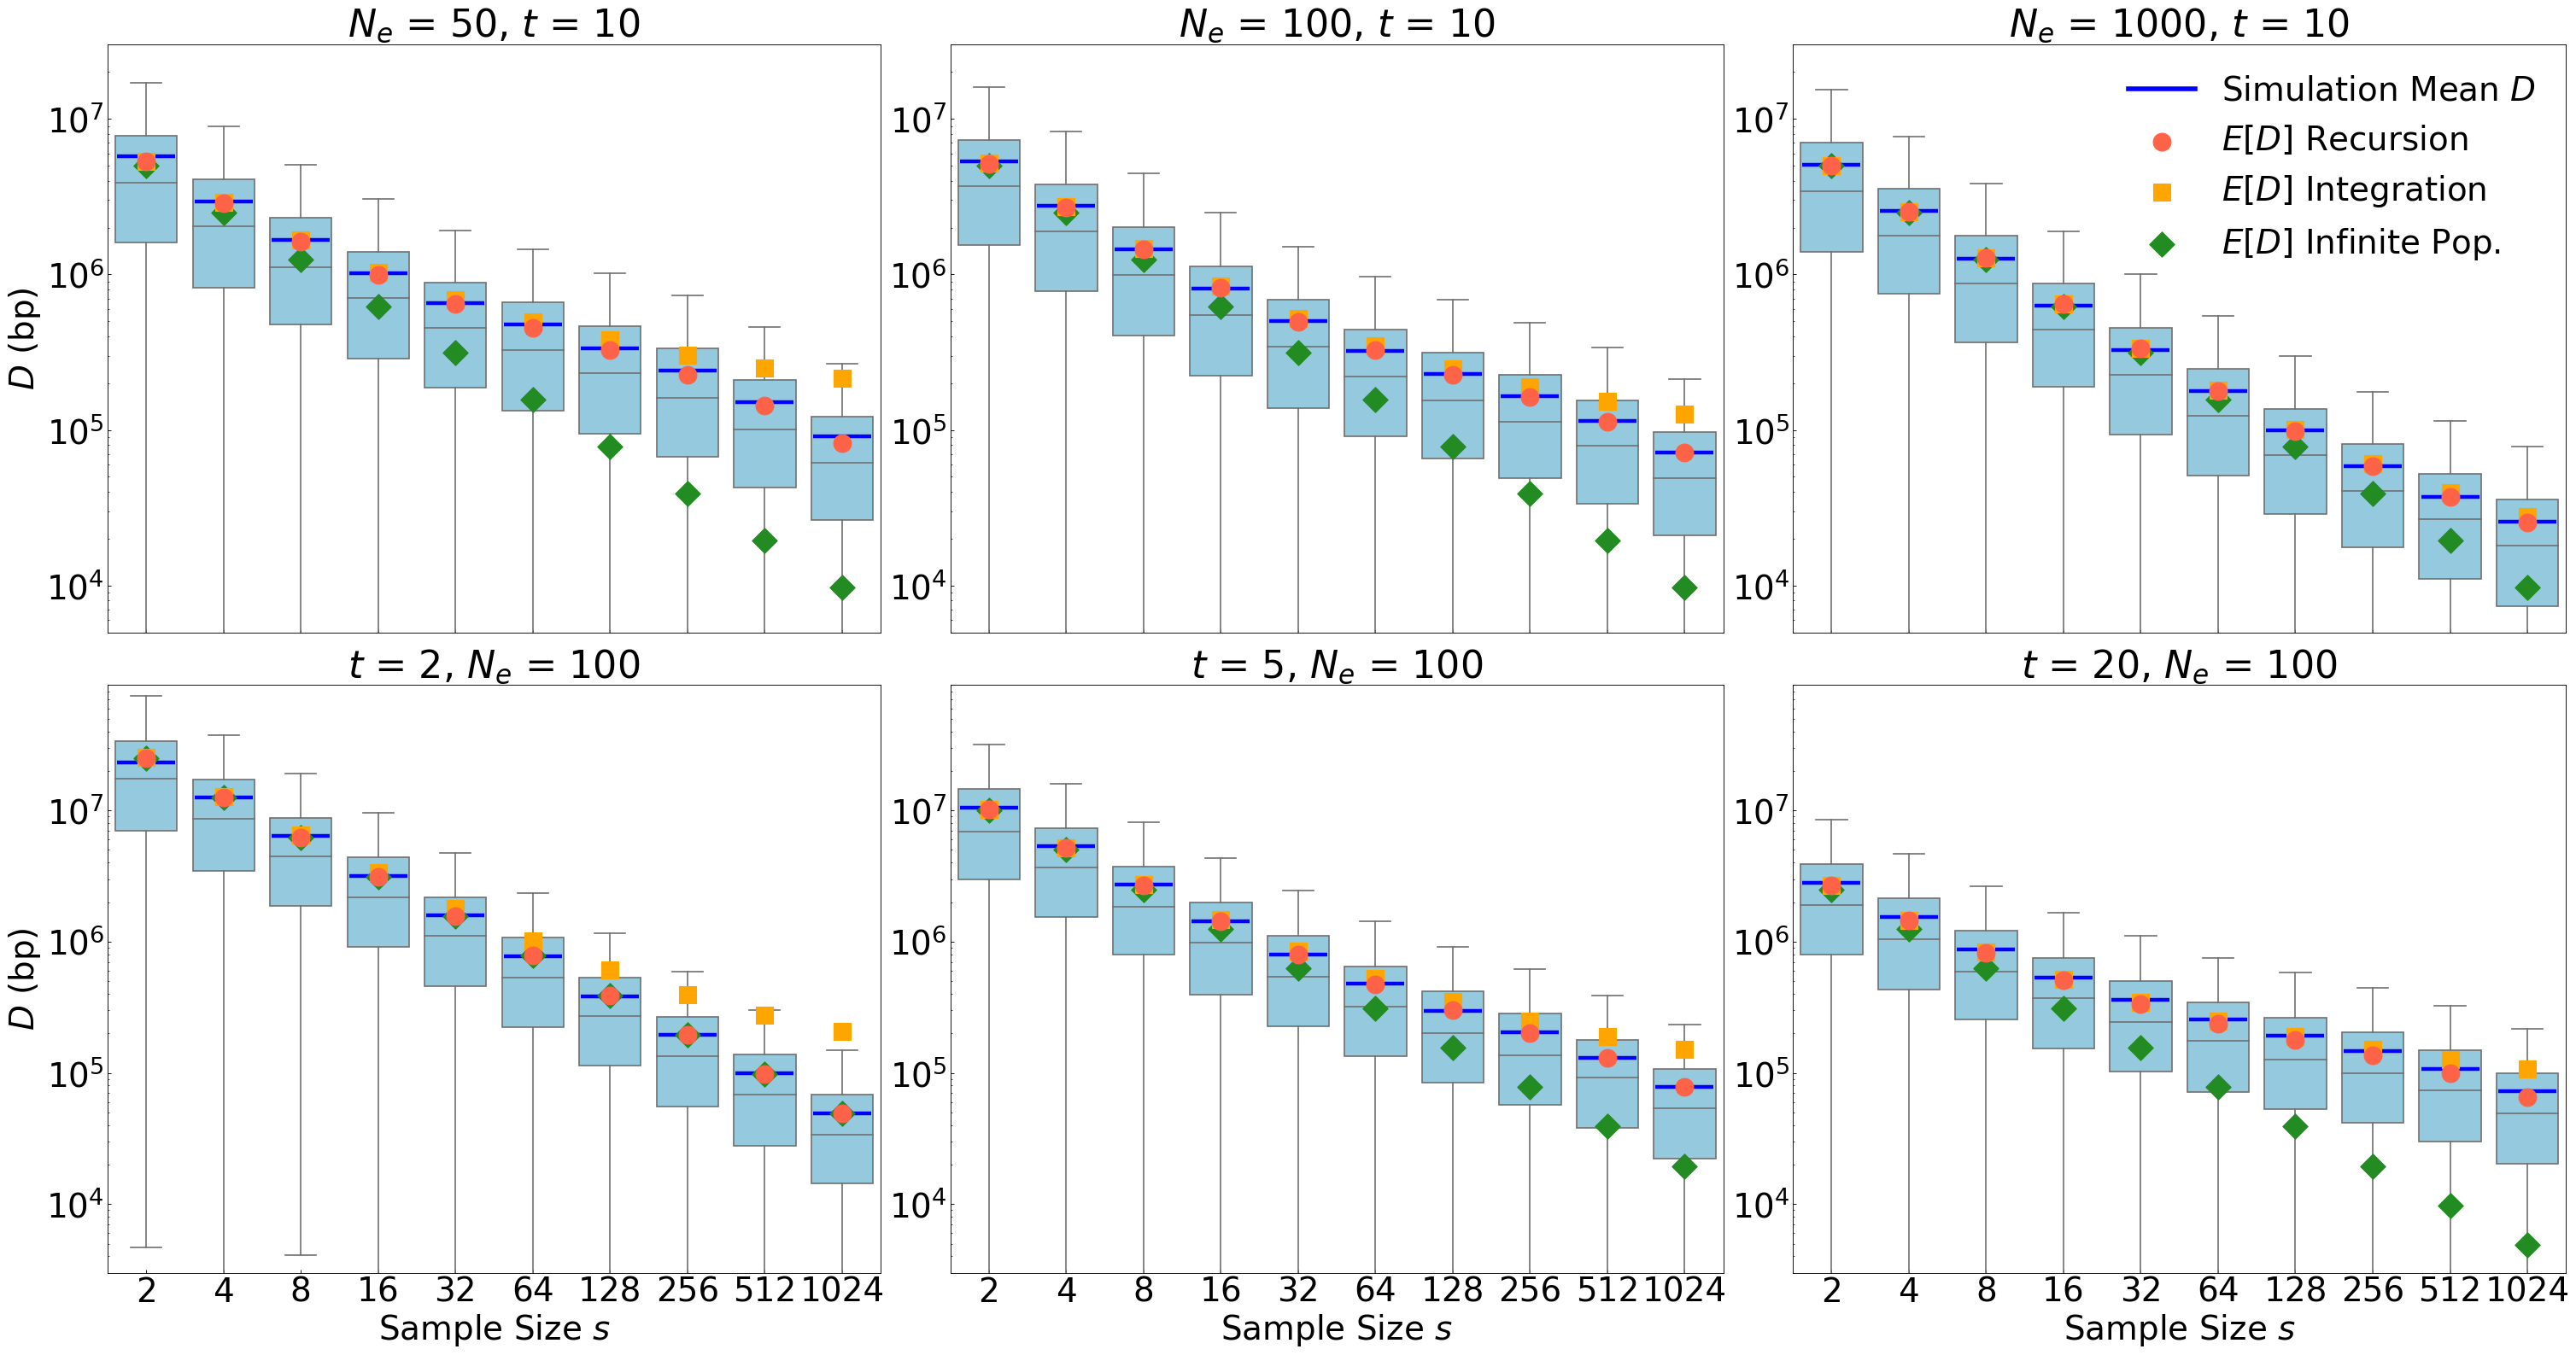

In [22]:
R = 1e-8
S_s = [2**x for x in range(1,11)]
gs = [2, 5, 20]
Nes = [50, 100, 1000]
fig, axes = plt.subplots(2,3)
fig.set_size_inches((38,20))
for row_idx in range(2):
    for col_idx in range(3):
        if (row_idx == 0):
            T = 10
            ax = axes[row_idx, col_idx]
            Ne = Nes[col_idx]
            # title
            ax.set_title('$N_e$ = {}, $t$ = {}'.format(Ne,T), fontsize=40)
            pckl_file = 'BSA_Open-win_Res_100MbChrom_Ne{}_Gen11_1.0cM_5kSims.pckl'.format(Ne)
        else:
            ax = axes[row_idx, col_idx]
            T = gs[col_idx]
            Ne = 100
            # title
            ax.set_title('$t$ = {}, $N_e$ = {}'.format(T, Ne,float(R)/1e-8), fontsize=40)
            pckl_file = 'BSA_Open-win_Res_100MbChrom_Ne100_Gen{}_1.0cM_5kSims.pckl'.format(T+1, Ne)
        
        with open(pckl_file, 'rb') as f: 
            resolution_all = pickle.load(f)     
        # Plot the data
        sample_sizes = []
        simulation_resolutions = []
        resolution_arrays = []
        for S, resolution in resolution_all.items():
            res = np.array(resolution)
            res = res[res!=np.inf]
            simulation_resolutions += list(res)
            sample_sizes += [S] * len(res)
            resolution_arrays.append(res)

        dict_ = {'Sample_size': sample_sizes, 'resolution': simulation_resolutions}
        df_ = pd.DataFrame(dict_)
        resolutions = np.array([calc_BSA_open_win_res_fin(Ne, float(R), S, T) for S in S_s])
#         print('Approx:', resolutions)
        resolutions_ = np.array([calc_BSA_open_win_res_recursion(Ne, float(R), S, T) for S in S_s])
#         print('Recursion:', resolutions_)
        resolutions_inf = [calc_BSA_open_win_res_inf(float(R), S, T) for S in S_s]
        simulation_means = [np.mean(df_[df_['Sample_size'] == s]['resolution']) for s in S_s]
#         print('Simulations:', simulation_means)
        error = np.abs(np.divide(np.array(resolutions) - np.array(simulation_means), np.array(simulation_means)))
#         print(Ne, S, T, '% Error: ', np.mean(error), np.std(error))
        
        # Plot the data
        sns.boxplot(x="Sample_size", y="resolution", data=df_, ax=ax, color="skyblue", showfliers=False, showmeans=True, 
                   meanprops={"marker":"_","markeredgecolor":"blue", "mew":4, "markersize":62})
        ax.scatter(range(0, len(S_s)), resolutions_inf, marker='D', s=350,label='$E[D]$ Infinite Pop.', color='forestgreen',zorder=10)
        ax.scatter(range(0, len(S_s)), resolutions, marker='s', s=300,label='$E[D]$ Integration', color='orange', zorder=10)
        ax.scatter(range(0, len(S_s)), resolutions_, marker='o', s=350, color='tomato', label='$E[D]$ Recursion',zorder=10)
        ax.set_yscale('log', basey=10)
        
        ax.yaxis.set_tick_params(labelsize=35)
        ax.xaxis.set_tick_params(labelsize=35)
        
        if (col_idx == 0):
            ax.set_ylabel("$D$ (bp)", fontsize=35)
        else:
            ax.set_ylabel("")
            
        if (row_idx == 1):
            ax.set_ylim((10**4-7e3, 10**7+8e7))
            ax.set_xlabel("Sample Size $s$", fontsize=35)
        else:
            ax.set_ylim((10**4-5e3, 10**7+2e7))
            ax.set_xlabel("")
            ax.set_xticklabels('')
# Legends
handles, labels = ax.get_legend_handles_labels()
handles += [Line2D([0], [0], color='b', linewidth=5, marker='_')]
labels += ['Simulation Mean $D$']
order = [3,2,1,0]
axes[0,2].legend([handles[idx] for idx in order],[labels[idx] for idx in order],markerscale=1, loc='upper right',frameon=False,fontsize=35)

plt.tight_layout()
plt.subplots_adjust(hspace=0.09, wspace = 0.09)
plt.savefig('BSA_Resolution_vs_S_100Mb_NV.pdf', dpi=400)

## Figure 6: Other Experiments Numerical Validation
### HC vs IM Numerical Validation

[2680252.41653192, 1454717.2996013537, 834693.9588588973, 514914.7115552341, 343815.4836035709, 247129.79578522049]
[3260520.4586, 1696419.1176, 913892.7798, 540580.857, 346808.6482, 239168.6998]


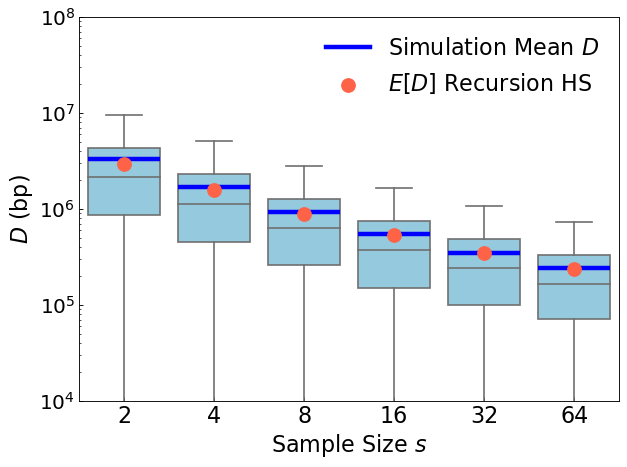

In [14]:
R = 1e-8
T = 10
S_s = [2**x for x in range(1,7)]
Ne = 100
fig, axes = plt.subplots()
fig.set_size_inches((8,6))

pckl_file = 'HC_Open-win_Res_100MbChrom_Ne100_Gen11_1.0cM_5kSims.pckl'
with open(pckl_file, 'rb') as f: 
    resolution_all = pickle.load(f)

# Plot the data
sample_sizes = []
simulation_resolutions = []
resolution_arrays = []
for S, resolution in resolution_all.items():
    res = np.array(resolution)
    res = res[res!=np.inf]
    simulation_resolutions += list(res)
    sample_sizes += [S] * len(res)
    resolution_arrays.append(res)

# print(resolution_arrays)
dict_ = {'Sample_size': sample_sizes, 'resolution': simulation_resolutions}
df_ = pd.DataFrame(dict_)
resolutions = [calc_HS_open_win_res_fin(Ne, float(R), S, T) for S in S_s]
resolutions_ = np.array([calc_HS_open_win_res_fin_recursion(Ne, float(R), S, T) for S in S_s])
simulation_means = [np.mean(df_[df_['Sample_size'] == s]['resolution']) for s in S_s]
print(resolutions)
print(simulation_means)

# Plot the data
# sns.boxplot(x="Sample_size", y="resolution", data=df_, ax=axes[1], color="mistyrose", showfliers=False)
sns.boxplot(x="Sample_size", y="resolution", data=df_, ax=axes, color="skyblue", showfliers=False, showmeans=True, 
                   meanprops={"marker":"_","markeredgecolor":"blue", "mew":4, "markersize":65})
axes.scatter(range(0, len(S_s)), resolutions_, marker='o', s=150, color='tomato', label='$E[D]$ Recursion HS',zorder=10)

axes.set_ylabel("$D$ (bp)", fontsize=20)
axes.set_yscale('log', basey=10)
axes.set_ylim((10**4, 10**8))

axes.set_xlabel("Sample Size $s$", fontsize=20)
axes.xaxis.set_tick_params(labelsize=20)

handles, labels = axes.get_legend_handles_labels()
handles += [Line2D([0], [0], color='b', linewidth=4, marker='_')]
labels += ['Simulation Mean $D$']
order = [1,0]
axes.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
            markerscale=1, loc='upper right',frameon=False,fontsize=20)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.05)
plt.savefig('Open-window_Res_vs_S_100Mb_HS.png', dpi=400)

[5695762.84750048, 3275958.10636077, 2026677.8071262632, 1357104.635255419, 977884.9850918752, 748638.5866402526]
[5220400.0, 2741940.0, 1684710.0, 1092240.0, 696650.0, 491379.6576032226]


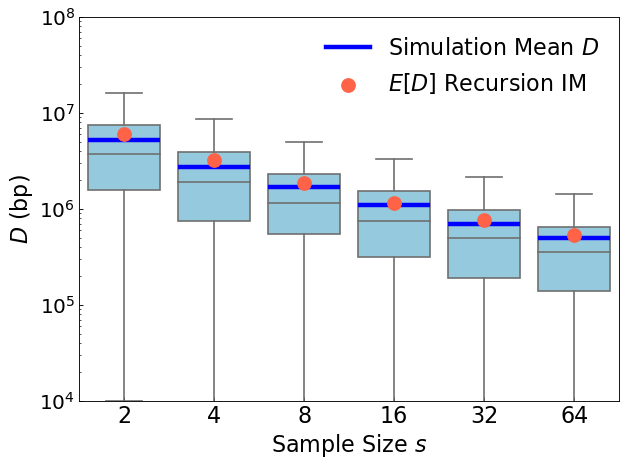

In [15]:
R = 1e-8
T = 10
S_s = [2**x for x in range(1,7)]
Ne = 100
fig, axes = plt.subplots()
fig.set_size_inches((8,6))

pckl_file = 'IM_Open-win_Res_100MbChrom_Ne100_Gen11_1.0cM_Non-TreeSeq_5kSims.pckl'
with open(pckl_file, 'rb') as f: 
    resolution_all = pickle.load(f)

# Plot the data
sample_sizes = []
simulation_resolutions = []
resolution_arrays = []
for S, resolution in resolution_all.items():
    res = np.array(resolution)
    res = res[res!=np.inf]
    simulation_resolutions += list(res)
    sample_sizes += [S] * len(res)
    resolution_arrays.append(res)

# print(resolution_arrays)
dict_ = {'Sample_size': sample_sizes, 'resolution': simulation_resolutions}
df_ = pd.DataFrame(dict_)
resolutions = [calc_IM_open_win_res_fin(Ne, float(R), S, T) for S in S_s]
resolutions_ = np.array([calc_IM_open_win_res_fin_recursion(Ne, float(R), S, T) for S in S_s])
simulation_means = [np.mean(df_[df_['Sample_size'] == s]['resolution']) for s in S_s]
print(resolutions)
print(simulation_means)

# Plot the data
sns.boxplot(x="Sample_size", y="resolution", data=df_, ax=axes, color="skyblue", showfliers=False, showmeans=True, 
                   meanprops={"marker":"_","markeredgecolor":"blue", "mew":4, "markersize":65})
axes.scatter(range(0, len(S_s)), resolutions_, marker='o', s=150, color='tomato', label='$E[D]$ Recursion IM', zorder=10)

axes.set_ylabel("$D$ (bp)", fontsize=20)
axes.set_yscale('log', basey=10)
axes.set_ylim((10**4, 10**8))

axes.set_xlabel("Sample Size $s$", fontsize=20)
axes.xaxis.set_tick_params(labelsize=20)

handles, labels = axes.get_legend_handles_labels()
handles += [Line2D([0,0.5], [0,0.5], color='b', linewidth=4, marker='_')]
labels += ['Simulation Mean $D$']
order = [1,0]
axes.legend([handles[idx] for idx in order],[labels[idx] for idx in order],markerscale=1, loc='upper right',frameon=False,fontsize=20)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.05)
plt.savefig('Open-window_Res_vs_S_100Mb_IM.png', dpi=400)

## Figure 7: BSA experiment with short-read sequencing

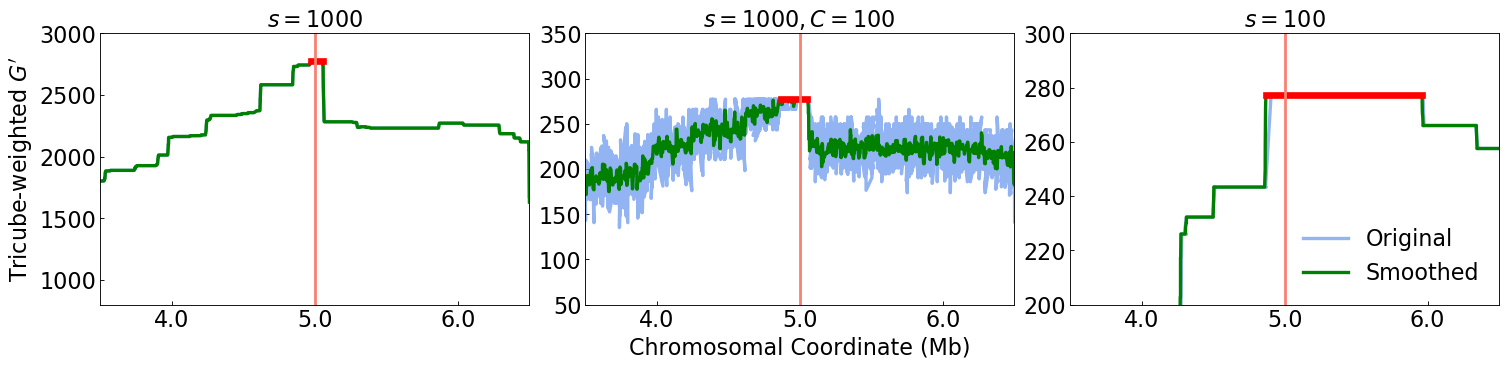

In [21]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches((19,5))

pckl_file = 'BSA_Resolution_vs_Statistics_s1000_noCov.pckl'
with open(pckl_file, 'rb') as f:
    all_snp_g_dict_s1000, all_snp_gprime_dict_s1000 = pickle.load(f)
    
axes[0].plot(list(all_snp_gprime_dict_s1000.keys()), list(all_snp_gprime_dict_s1000.values()), linewidth=3,color='cornflowerblue', label='Original', alpha=0.7)
axes[0].plot(list(all_snp_gprime_dict_s1000.keys()), list(all_snp_gprime_dict_s1000.values()), linewidth=3,color='green', label='Smoothed')
max_window = list(filter(lambda x: np.isclose(x[1],max(all_snp_gprime_dict_s1000.values())), all_snp_gprime_dict_s1000.items()))
max_window_bounds = (max_window[0][0], max_window[-1][0])
axes[0].axhline(y=max(all_snp_gprime_dict_s1000.values()), xmin=(max_window_bounds[0]-3.5e6)/3e6, 
                xmax=(max_window_bounds[1]-3.5e6)/3e6, color='red', linewidth=6)
axes[0].set_ylim((800,3000))

pckl_file = 'BSA_Resolution_vs_Statistics_s1000_cov100.pckl'
with open(pckl_file, 'rb') as f:
    all_snp_g_dict_s1000_c100, all_snp_gprime_dict_s1000_c100 = pickle.load(f)
axes[1].plot(list(all_snp_g_dict_s1000_c100.keys()), list(all_snp_g_dict_s1000_c100.values()), linewidth=3,color='cornflowerblue', label='Original', alpha=0.7)
axes[1].plot(list(all_snp_gprime_dict_s1000_c100.keys()), list(all_snp_gprime_dict_s1000_c100.values()), linewidth=3,color='green', label='Smoothed')
max_window = list(filter(lambda x: np.isclose(x[1],max(all_snp_gprime_dict_s1000_c100.values())), all_snp_gprime_dict_s1000_c100.items()))
max_window_bounds = (max_window[0][0], max_window[-1][0])
axes[1].axhline(y=max(all_snp_gprime_dict_s1000_c100.values()), xmin=(max_window_bounds[0]-3.5e6)/3e6, 
                xmax=(max_window_bounds[1]-3.5e6)/3e6, color='red', linewidth=6)
axes[1].set_ylim((50,350))

pckl_file = 'BSA_Resolution_vs_Statistics_s100_noCov.pckl'
with open(pckl_file, 'rb') as f:
    all_snp_g_dict_s1000, all_snp_gprime_dict_s1000 = pickle.load(f)
axes[2].plot(list(all_snp_g_dict_s1000.keys()), list(all_snp_g_dict_s1000.values()), linewidth=3,color='cornflowerblue', label='Original', alpha=0.7)
axes[2].plot(list(all_snp_gprime_dict_s1000.keys()), list(all_snp_gprime_dict_s1000.values()), linewidth=3,color='green', label='Smoothed')
max_window = list(filter(lambda x: np.isclose(x[1],max(all_snp_gprime_dict_s1000.values())), all_snp_gprime_dict_s1000.items()))
max_window_bounds = (max_window[0][0], max_window[-1][0])
axes[2].axhline(y=max(all_snp_gprime_dict_s1000.values()), xmin=(max_window_bounds[0]-3.5e6)/3e6, 
                xmax=(max_window_bounds[1]-3.5e6)/3e6, color='red', linewidth=6)
axes[2].set_ylim((200,300))
axes[0].set_ylabel("Tricube-weighted $\it{G\'}$", fontsize=20)
axes[1].set_ylabel("", fontsize=20)
# ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for ax in axes:
    ax.set_xlim(3.5e6-1, 6.5e6+1)
    ax.set_xticklabels(ax.get_xticks())
    ax.yaxis.set_tick_params(labelsize=20)
    ax.xaxis.set_tick_params(labelsize=20)

    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = [str(int(float(loc)) / 10**6) for loc in labels]
    ax.set_xticklabels(labels)
    ax.axvline(5e6, color='salmon', linewidth=2.5)
#     ax.axvline(5e6, color='salmon', linewidth=2.5,label='Causal Mutation')

axes[1].set_xlabel("Chromosomal Coordinate (Mb)", fontsize=20)
axes[2].legend(fontsize=20, loc='lower right', frameon=False)
# axes[2].legend(fontsize=15, loc='lower right', frameon=False)

axes[0].set_title("$s=1000$", fontsize=20)
axes[1].set_title("$s=1000, C=100$", fontsize=20)
axes[2].set_title("$s=100$", fontsize=20)
# plt.suptitle("Simulated BSA Experiment: $N_e$ = {}, $t$ = {}, $r$ = {}cM/Mb".format(Ne, T, float(R)/1e-8), fontsize=20)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.13, top=0.85)
# plt.savefig('BSA_Summary_Stats_Ne_100_1cM_s1e3_C100.pdf',dpi=400)